In [ ]:
# colab 사용시 드라이브 연결

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# colab 사용시 py-hanspell 설치
!pip install git+https://github.com/ssut/py-hanspell.git

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
from tqdm import tqdm

import warnings 
warnings.filterwarnings('ignore')

import random
from hanspell import spell_checker
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
path = '/content/drive/MyDrive/통계데이터센터/'

In [4]:
train = pd.read_csv(path + '1. 실습용자료.txt', sep='|', encoding='cp949')
test = pd.read_csv(path + '2. 모델개발용자료.txt', sep='|', encoding='cp949')
ksic = pd.read_excel(path + '산업분류표.xlsx')
ksic = ksic.iloc[:1192,:]

In [5]:
train.drop(columns=['AI_id'],inplace=True)
test.drop(columns=['AI_id'],inplace=True)

In [7]:
# 한글과 영어를 제외하고 모두 제거
# text_obj, text_mthd, text_deal를 하나로 합치기

def combinetext(df,t1,t2,t3):
  df2 = df.copy()
  df2.fillna(' ',inplace=True)
  df2[t1] = df2[t1].str.replace('[^A-Za-z가-힣]', ' ')
  df2[t1] = df2[t1].str.replace('^ +', "")
  # df2[t1].replace('', np.nan, inplace=True)

  df2[t2] = df2[t2].str.replace('[^A-Za-z가-힣]', ' ')
  df2[t2] = df2[t2].str.replace('^ +', "")
  # df2[t2].replace('', np.nan, inplace=True)

  df2[t3] = df2[t3].str.replace('[^A-Za-z가-힣]', ' ')
  df2[t3] = df2[t3].str.replace('^ +', "")
  # df2[t3].replace('', np.nan, inplace=True)

  df2['text'] = df2[t1]+' '+df2[t2]+' '+df2[t3]

  df2['text'] = df2['text'].str.replace('[^A-Za-z가-힣]', ' ')
  df2['text'] = df2['text'].str.replace('^ +', " ")
  df2['text'].replace('', np.nan, inplace=True)

  df2[t1].replace('', np.nan, inplace=True)
  df2[t2].replace('', np.nan, inplace=True)
  df2[t3].replace('', np.nan, inplace=True)

  return df2

In [8]:
train1 = combinetext(train,'text_obj','text_mthd','text_deal')
train2 = combinetext(ksic,'text1','text4','text5')
train2.drop(columns=['text2','text3'],inplace=True)
train2.columns = train1.columns

train = pd.concat([train1,train2])
train = train[(train['digit_3'] != 13) & (train['digit_3'] != 15) & (train['digit_3'] != 52)]

test = combinetext(test,'text_obj','text_mthd','text_deal')

train  = train[train['text'].notna()]
# test  = test[test['text'].notna()]

train.reset_index(drop=True,inplace=True)

In [96]:
train.head()

,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal,text
0,S,95,952,카센터에서,자동차부분정비,타이어오일교환,카센터에서 자동차부분정비 타이어오일교환
1,G,47,472,상점내에서,일반인을 대상으로,채소 과일판매,상점내에서 일반인을 대상으로 채소 과일판매
2,G,46,467,절단하여사업체에도매,공업용고무를가지고,합성고무도매,절단하여사업체에도매 공업용고무를가지고 합성고무도매
3,G,47,475,영업점에서,일반소비자에게,열쇠잠금장치,영업점에서 일반소비자에게 열쇠잠금장치
4,Q,87,872,어린이집,보호자의 위탁을 받아,취학전아동보육,어린이집 보호자의 위탁을 받아 취학전아동보육


In [97]:
test.head()

,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal,text
0,,,,치킨전문점에서,고객의주문에의해,치킨판매,치킨전문점에서 고객의주문에의해 치킨판매
1,,,,산업공구,다른 소매업자에게,철물 수공구,산업공구 다른 소매업자에게 철물 수공구
2,,,,절에서,신도을 대상으로,불교단체운영,절에서 신도을 대상으로 불교단체운영
3,,,,영업장에서,고객요구로,자동차튜닝,영업장에서 고객요구로 자동차튜닝
4,,,,실내포장마차에서,접객시설을 갖추고,소주 맥주제공,실내포장마차에서 접객시설을 갖추고 소주 맥주제공


In [98]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001189 entries, 0 to 1001188
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   digit_1    1001189 non-null  object
 1   digit_2    1001189 non-null  int64 
 2   digit_3    1001189 non-null  int64 
 3   text_obj   984502 non-null   object
 4   text_mthd  957561 non-null   object
 5   text_deal  933517 non-null   object
 6   text       1001189 non-null  object
dtypes: int64(2), object(5)
memory usage: 53.5+ MB


In [99]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   digit_1    100000 non-null  object
 1   digit_2    100000 non-null  object
 2   digit_3    100000 non-null  object
 3   text_obj   98188 non-null   object
 4   text_mthd  97031 non-null   object
 5   text_deal  93833 non-null   object
 6   text       100000 non-null  object
dtypes: object(7)
memory usage: 5.3+ MB


In [ ]:
# 맞춤법 검사
tqdm.pandas()
train['text'] = train['text'].progress_apply(lambda x: spell_checker.check(x).as_dict()['checked'])

# 중복된 값 제거 (약 363638개)
train = train.drop_duplicates(subset=['text'])

# 전처리한 train 파일 저장
train.to_csv(path + 'train_preprocessing.csv', index=False, encoding='cp949')

In [ ]:
tqdm.pandas()
test['text'] = test['text'].progress_apply(lambda x: spell_checker.check(x).as_dict()['checked'])

# 전처리한 test 파일 저장
test.to_csv(path + 'test_preprocessing.csv', index=False, encoding='cp949')

In [101]:
# 결측치 확인
print('train 결측값 개수 : ',sum(train['text'].isnull()))
print('test 결측값 개수 : ',sum(test['text'].isnull()))

train 결측값 개수 :  0
test 결측값 개수 :  0


In [102]:
# 레이블(label) 값 분포 불균형 확인
train['digit_3'].value_counts()

561    123719
562     49762
493     49119
961     43047
492     39184
        ...  
80          4
120         4
652         3
61          2
51          2
Name: digit_3, Length: 225, dtype: int64

In [112]:
train_length = train['text'].apply(len)

print('text 길이 최대값 : {}'.format(np.max(train_length)))
print('text 길이 최소값 : {}'.format(np.min(train_length)))
print('text 길이 평균값 : {:.2f}'.format(np.mean(train_length)))
print('text 길이 표준편차 : {:.2f}'.format(np.std(train_length)))
print('text 길이 중간값 : {}'.format(np.median(train_length)))
print('text 길이 제1사분위 : {}'.format(np.percentile(train_length, 25)))
print('text 길이 제3사분위 : {}'.format(np.percentile(train_length, 75)))

text 길이 최대값 : 89
text 길이 최소값 : 2
text 길이 평균값 : 22.18
text 길이 표준편차 : 6.24
text 길이 중간값 : 22.0
text 길이 제1사분위 : 19.0
text 길이 제3사분위 : 26.0


In [113]:
train_word_counts = train['text'].apply(lambda x:len(x.split(' ')))
print('단어 개수 최대값 : {}'.format(np.max(train_word_counts)))
print('단어 개수 최소값 : {}'.format(np.min(train_word_counts)))
print('단어 개수 평균값 : {:.2f}'.format(np.mean(train_word_counts)))
print('단어 개수 표준편차 : {:.2f}'.format(np.std(train_word_counts)))
print('단어 개수 중간값 : {}'.format(np.median(train_word_counts)))

단어 개수 최대값 : 25
단어 개수 최소값 : 1
단어 개수 평균값 : 5.64
단어 개수 표준편차 : 1.70
단어 개수 중간값 : 5.0


Text(0, 0.5, '빈도 수')

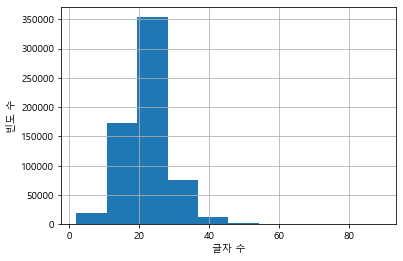

In [85]:
#train text의 글자 수 히스토그램 
ax = train['text'].str.len().hist() 
ax.set_xlabel('글자 수') 
ax.set_ylabel('빈도 수')


Text(0, 0.5, '빈도 수')

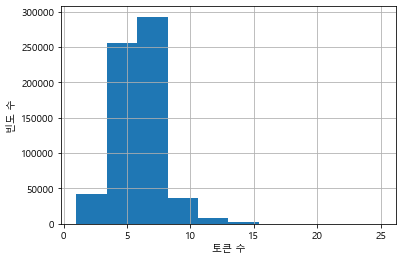

In [86]:
#토큰 수 
ax =train['text'].str.split().map(lambda x: len(x)).hist() 
ax.set_xlabel('토큰 수') 
ax.set_ylabel('빈도 수')


Text(0, 0.5, '빈도 수')

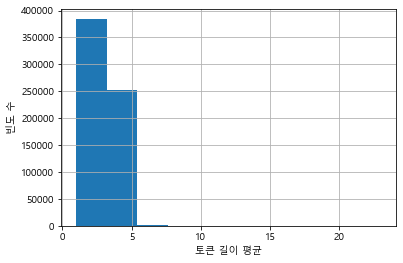

In [89]:
#토큰별 길이 평균 
ax = train['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist() 
ax.set_xlabel('토큰 길이 평균') 
ax.set_ylabel('빈도 수')


In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['text'])
x_train_encoded = tokenizer.texts_to_sequences(train['text'])

In [10]:
max(len(l) for l in x_train_encoded)

25

In [11]:
sum(map(len, x_train_encoded))/len(x_train_encoded)

5.817603611318938